In [1]:
import sys
import os
from threading import Thread

import matplotlib.pyplot as plt
import numpy as np
from qclib.util import get_state
from qiskit import transpile
from qiskit.extensions import Initialize

from q_alchemy.qiskit import QAlchemyInitialize

sys.path.append('..')
os.environ["Q_ALCHEMY_API_KEY"] = "<your api key>"

In [2]:
def plot_digits(digits, labels, text, matrix_dim):
    _, axes = plt.subplots(nrows=1, ncols=len(digits), figsize=(20, 10))
    for ax, digit, label in zip(axes, digits, labels):
        ax.set_axis_off()
        image = digit[:int(matrix_dim**2)].reshape(matrix_dim, matrix_dim)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
        ax.set_title(label)

    plt.show()

In [5]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, parser="auto")

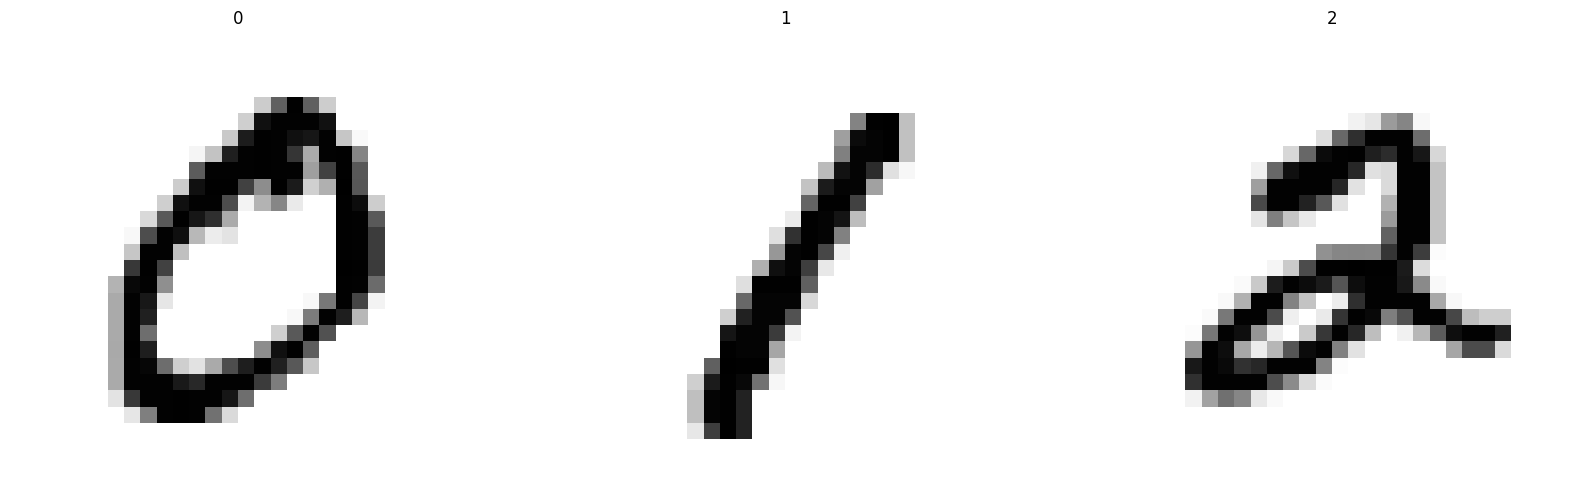

In [6]:
zero: np.ndarray = mnist.data[mnist.target == "0"].iloc[0].to_numpy()
one: np.ndarray = mnist.data[mnist.target == "1"].iloc[0].to_numpy()
two: np.ndarray = mnist.data[mnist.target == "2"].iloc[0].to_numpy()

filler = np.empty(2**10 - zero.shape[0])
filler.fill(0)

zero = np.hstack([zero, filler])
one = np.hstack([one, filler])
two = np.hstack([two, filler])

zero = zero / np.linalg.norm(zero)
one = one / np.linalg.norm(one)
two = two / np.linalg.norm(two)

plot_digits([zero, one, two], [0, 1, 2], "test", 28)

# Looking at the 0

In [9]:
def get_comparison_data(d: np.ndarray):
    
    qs_org = Initialize(d.tolist())
    qs_qc = transpile(qs_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    state = np.real(get_state(qs_org.definition)**2)
    cx_length = len(qs_qc.get_instructions("cx"))
    
    threads = []
    result = [
        [-1.0, cx_length, state]
    ]
    for fidelity_loss in np.linspace(0.0, 1.0, 11):
        def func(fl):
            sp_org = QAlchemyInitialize(d.tolist(), opt_params={'max_fidelity_loss': fl, "use_result_after_sec": None})
            qc = transpile(sp_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
            sp_length = len(qc.get_instructions("cx"))
            sp_state = np.real(get_state(sp_org.definition)**2)
            result.append([fl, sp_length, sp_state])
        job = Thread(target=func, args=(fidelity_loss,))
        job.start()
        threads.append(job)

    for x in threads: 
        x.join()
    
    return result

In [10]:
def plot_comparison(r):
    meta_data: np.ndarray = np.asarray([r[0:2] for r in r])
    sorting = meta_data[:, 0].argsort()
    meta_data = meta_data[sorting]
    
    image_data: np.ndarray = np.asarray([r[2] for r in r])
    image_data = image_data[sorting]
    
    labels = [f"{r[0]:.1f} @ {r[1]:n}cx" for r in meta_data]
    plot_digits(image_data, labels, "test", 28)

In [11]:
result_zero = get_comparison_data(zero)

In [12]:
result_one = get_comparison_data(one)

In [13]:
result_two = get_comparison_data(two)

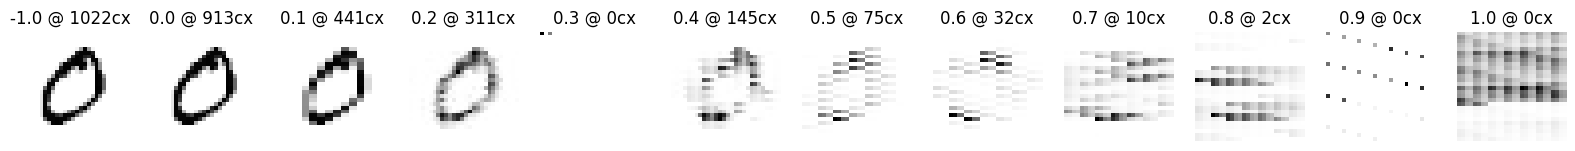

In [14]:
plot_comparison(result_zero)

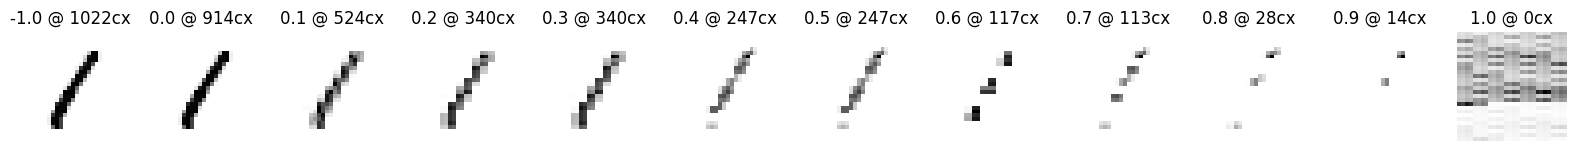

In [15]:
plot_comparison(result_one)

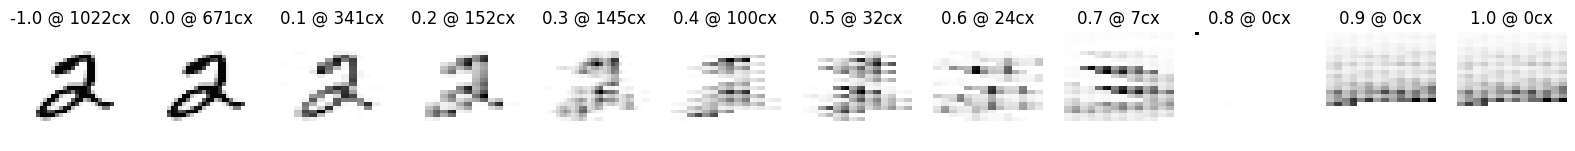

In [16]:
plot_comparison(result_two)